In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
import matplotlib.patheffects as path_effects

## Basic principle
Given a folder name we can gather all pathways from these trials, as well as all histories. AN efficient way to do this is using a table that links to the pathways. This is what ```get_organised``` does. It returns the name of algorithm (trial = Microbial), (NEAT = NEAT), (Diff = Differential) and (RL_TRIAL = Reinforcmnt learning). The name of the experiment isunder "experiment". And finaly the file is stored relating to it. It will be a numpy file


Once you have gathered this you can move onto processing the numpy files. Something to be aware of is not all routes make it to the end, so the arrays are filled with (0,0) to pad out the non values. Make sure to remove these from the plotting. Then you can use the ```get_arrays``` function to loop through all the trials or given trials as a parameter to get all routes for that.

In [10]:
def get_organised(base_dir = 'data',target_file = 'file to find'):
    rows = []
    # Walk through all subdirectories
    for root, dirs, files in os.walk(base_dir):
        if target_file in files:
            parts = os.path.normpath(root).split(os.sep)
            if len(parts) >= 3:
                grandparent = parts[-2]
                parent = parts[-1]
                file_path = os.path.join(root, target_file)
                rows.append((grandparent, parent, file_path))
    df = pd.DataFrame(rows, columns=['Algorithm', 'Experiment', 'File'])
    return df

all_learning_routes=get_organised("/its/home/drs25/ant_trajectory/data/","routes_over_time.npy") #all files 
all_end_routes=get_organised("/its/home/drs25/ant_trajectory/data/","routes.npy") #all files 
fitnesses=get_organised("/its/home/drs25/ant_trajectory/data/","fitnesses.npy") #all files 
all_end_routes

,Algorithm,Experiment,File
0,trial,LONGER_TRIALS10,/its/home/drs25/ant_trajectory/data/trial/LONG...
1,trial,less_trials_for_speed20,/its/home/drs25/ant_trajectory/data/trial/less...
2,trial,standard_trial7,/its/home/drs25/ant_trajectory/data/trial/stan...
3,trial,standard_trial12,/its/home/drs25/ant_trajectory/data/trial/stan...
4,trial,standard_trial8,/its/home/drs25/ant_trajectory/data/trial/stan...
...,...,...,...
109,NEAT,less_trials_for_speed16,/its/home/drs25/ant_trajectory/data/NEAT/less_...
110,NEAT,standard_trial10,/its/home/drs25/ant_trajectory/data/NEAT/stand...
111,NEAT,less_trials_for_speed19,/its/home/drs25/ant_trajectory/data/NEAT/less_...
112,RL_TRIAL,test,/its/home/drs25/ant_trajectory/data/RL_TRIAL/t...


In [12]:
def get_arrays(frame,algorithm=""):
    ar=[]
    for index, row in frame.iterrows():
        alg=row['Algorithm']
        trial=row['Experiment']
        file_=row['File']
        if algorithm=="": #default get all
            ar.append(np.load(file_))
        elif algorithm==alg: ar.append(np.load(file_)) #if looking for one
    return ar

data=get_arrays(all_end_routes,"Diff")
dataall=get_arrays(all_end_routes,"")
fitness_array=get_arrays(fitnesses)
print(len(data),len(dataall),len(fitness_array))

35 114 114


## Plotting principles
Like mentioned before, not all data can be used so you need to select the useful parts of the routes. Below is an example of doing this

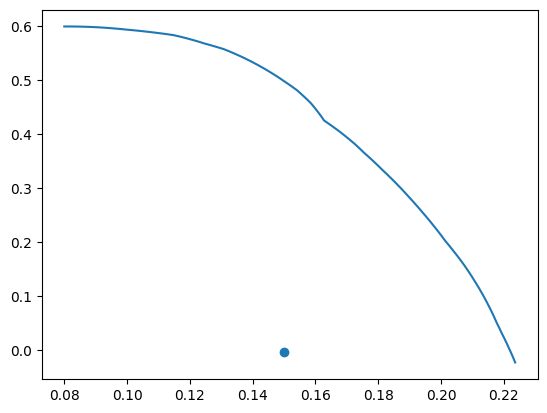

In [62]:
def get_used(routes):
    zero_index = np.argmax(np.all(routes == [0, 0], axis=1))
    if np.all(routes[zero_index] == [0, 0]):
        trimmed_coords = routes[:zero_index]
    else:
        trimmed_coords = routes  # No (0, 0) found

    return trimmed_coords
example_route=get_used(data[3][0])
plt.plot(example_route[:,0],example_route[:,1])
plt.scatter(0.15,-0.003)
plt.show()

### mass plots
We may want to plot all the plots at once, or even analyse frequency

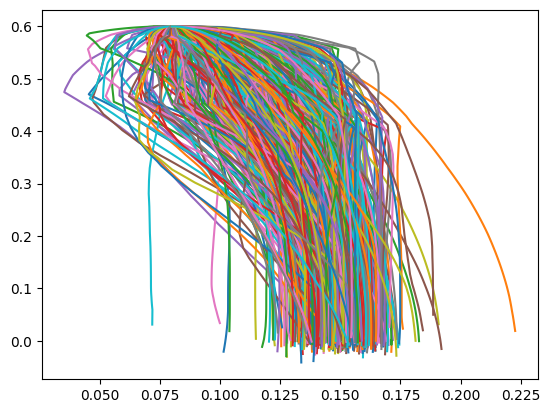

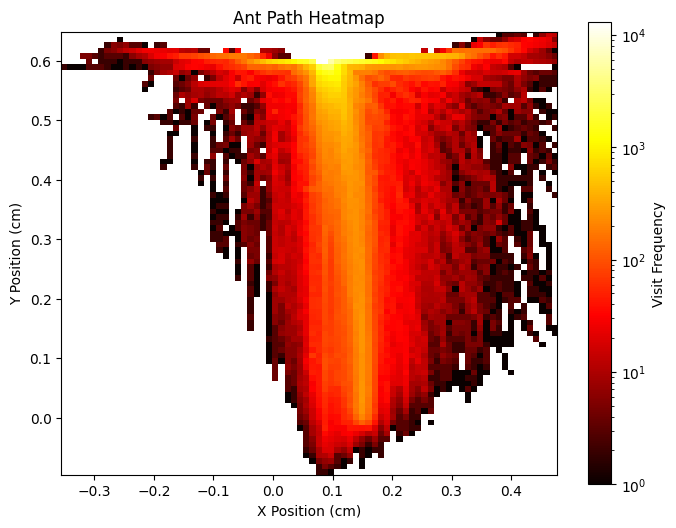

In [82]:
def plot_all(data): #takes in an array of trials, genotypes, timeframe, coordinates
    for i in range(len(data)):
        for g in range(len(data[i])):
            example_route=get_used(data[i][g])
            plt.plot(example_route[:,0],example_route[:,1])
    plt.scatter(0.15,-0.003)
    plt.show()

def plot_frequencies(data): #takes in an array of trials, genotypes, timeframe, coordinates
    all_x = []
    all_y = []
    initial_points=[]
    for i in range(len(data)):
        for g in range(len(data[i])):
            example_route=get_used(data[i][g])
            all_x.extend(example_route[:,0])
            all_y.extend(example_route[:,1])
            dx = example_route[0][0]
            dy = example_route[0][1]
            initial_points.append([dx, dy])
    initial_points=np.array(initial_points)
    initial_points=np.average(initial_points,axis=0)
    heatmap, xedges, yedges = np.histogram2d(all_x, all_y, bins=80)

    #plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        heatmap.T, origin='lower',
        extent=[min(all_x), max(all_x), min(all_y), max(all_y)],
        cmap='hot', interpolation='nearest',
        norm=LogNorm(vmin=1, vmax=heatmap.max())
    )

    plt.colorbar(label='Visit Frequency')
    #b=plt.scatter(initial_points[0],initial_points[1],c="b")
    #text = plt.text(initial_points[0]+1,initial_points[1]+1, "Food source", fontsize=12, color='white', weight='bold')
    """text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])
    b.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])"""
    plt.xlabel('X Position (cm)')
    plt.ylabel('Y Position (cm)')
    plt.title('Ant Path Heatmap')
    plt.show()

plot_all(data)
plot_frequencies(dataall)

### fitness

In [16]:
fitness_neat=get_arrays(fitnesses,"NEAT")
fitness_diff=get_arrays(fitnesses,"Diff")
fitness_trial=get_arrays(fitnesses,"trial")

def get_results(fitness):
    a=[]
    for i in range(len(fitness)):
        a.append(np.max(fitness[i]))
    a=np.array(a)
    return np.average(a),np.std(a)

print("NEAT",get_results(fitness_neat))
print("Diff",get_results(fitness_diff))
print("Microbial",get_results(fitness_trial))

NEAT (0.09792201907124452, 0.05913904772843482)
Diff (0.6025682599860129, 0.0029154550649666297)
Microbial (0.5767254425260112, 0.09751265345435943)


In [17]:
# get the best distances to the taget
def get_distance_results(data):
    mins=[]
    for i in range(len(data)):
        for g in range(len(data[i])):
            example_route=get_used(data[i][g])
            distances=np.linalg.norm(example_route-np.array([0.15,-0.003]))
            mins.append(np.min(distances))
    mins=np.array(mins)
    return np.average(mins),np.std(mins)
data_diff=get_arrays(all_end_routes,"Diff")
data_trial=get_arrays(all_end_routes,"trial")
data_neat=get_arrays(all_end_routes,"NEAT")
print("NEAT",get_distance_results(data_neat))
print("Diff",get_distance_results(data_diff))
print("Microbial",get_distance_results(data_trial))

## some other debugging stuff ignore

In [40]:
frame=get_organised("/its/home/drs25/ant_trajectory/data/","GA") #all files 
import pickle
import sys

sys.path.insert(1,"/its/home/drs25/ant_trajectory") #put path here
from GA_code.GAs.genetic_algorithm import GA
random_row = frame.sample(n=1).iloc[0] 
print(random_row)

obj = GA(100,10,2)
with open(random_row['File'], "wb") as f:
    pickle.dump(obj, f)


print(len(obj.best_genos_time))

Grandparent                                                trial
Parent                                           LONGER_TRIALS13
File           /its/home/drs25/ant_trajectory/data/trial/LONG...
Name: 28, dtype: object
0
